In [1]:
# # https://github.com/ari-dasci/OD-covidgr
# @misc{tabik2020covidgr,
#     title={COVIDGR dataset and COVID-SDNet methodology for predicting COVID-19 based on Chest X-Ray images},
#     author={S. Tabik and A. Gómez-Ríos and J. L. Martín-Rodríguez and I. Sevillano-García and M. Rey-Area and D. Charte and E. Guirado and J. L. Suárez and J. Luengo and M. A. Valero-González and P. García-Villanova and E. Olmedo-Sánchez and F. Herrera},
#     year={2020},
#     eprint={2006.01409},
#     archivePrefix={arXiv},
#     primaryClass={eess.IV}
# }

In [2]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import PIL 
import random
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.nn.functional as F


import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

Set Random Seed for reproducability

In [4]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

### 1.2 Generating Labels and Creating Sets for Modeling

Extract file links for both postive and negative images and split the dataset into train, validation, and test sets

In [5]:
path = 'C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets'

pos_files = glob.glob(f'{path}/P/*.*')
neg_files = glob.glob(f'{path}/N/*.*')

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, test_path, y_tv, test_label  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=random_seed)
train_path, valid_path, train_label, valid_label  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=random_seed)

In [6]:
len(train_path), len(test_path)

(510, 171)

From the plot below, observe that we have a balanced yet very small dataset at our disposal. Not ideal, but never the end of the road. Let's do our best to make the most out of what we have before we collect more data.

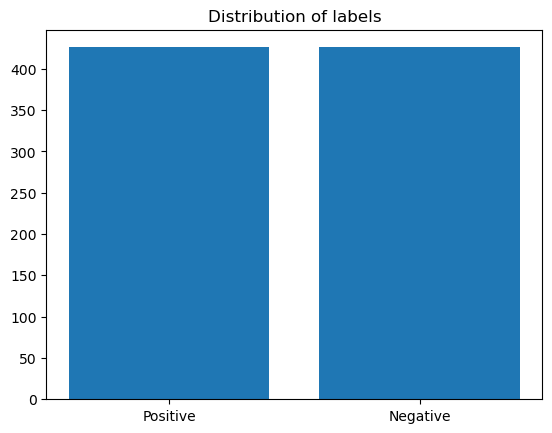

In [7]:
num_pos, num_neg = len(pos_files), len(neg_files)

plt.title('Distribution of labels')
plt.bar(['Positive', 'Negative'], [num_pos, num_neg])
plt.show()

Let's take a look at some of the images!

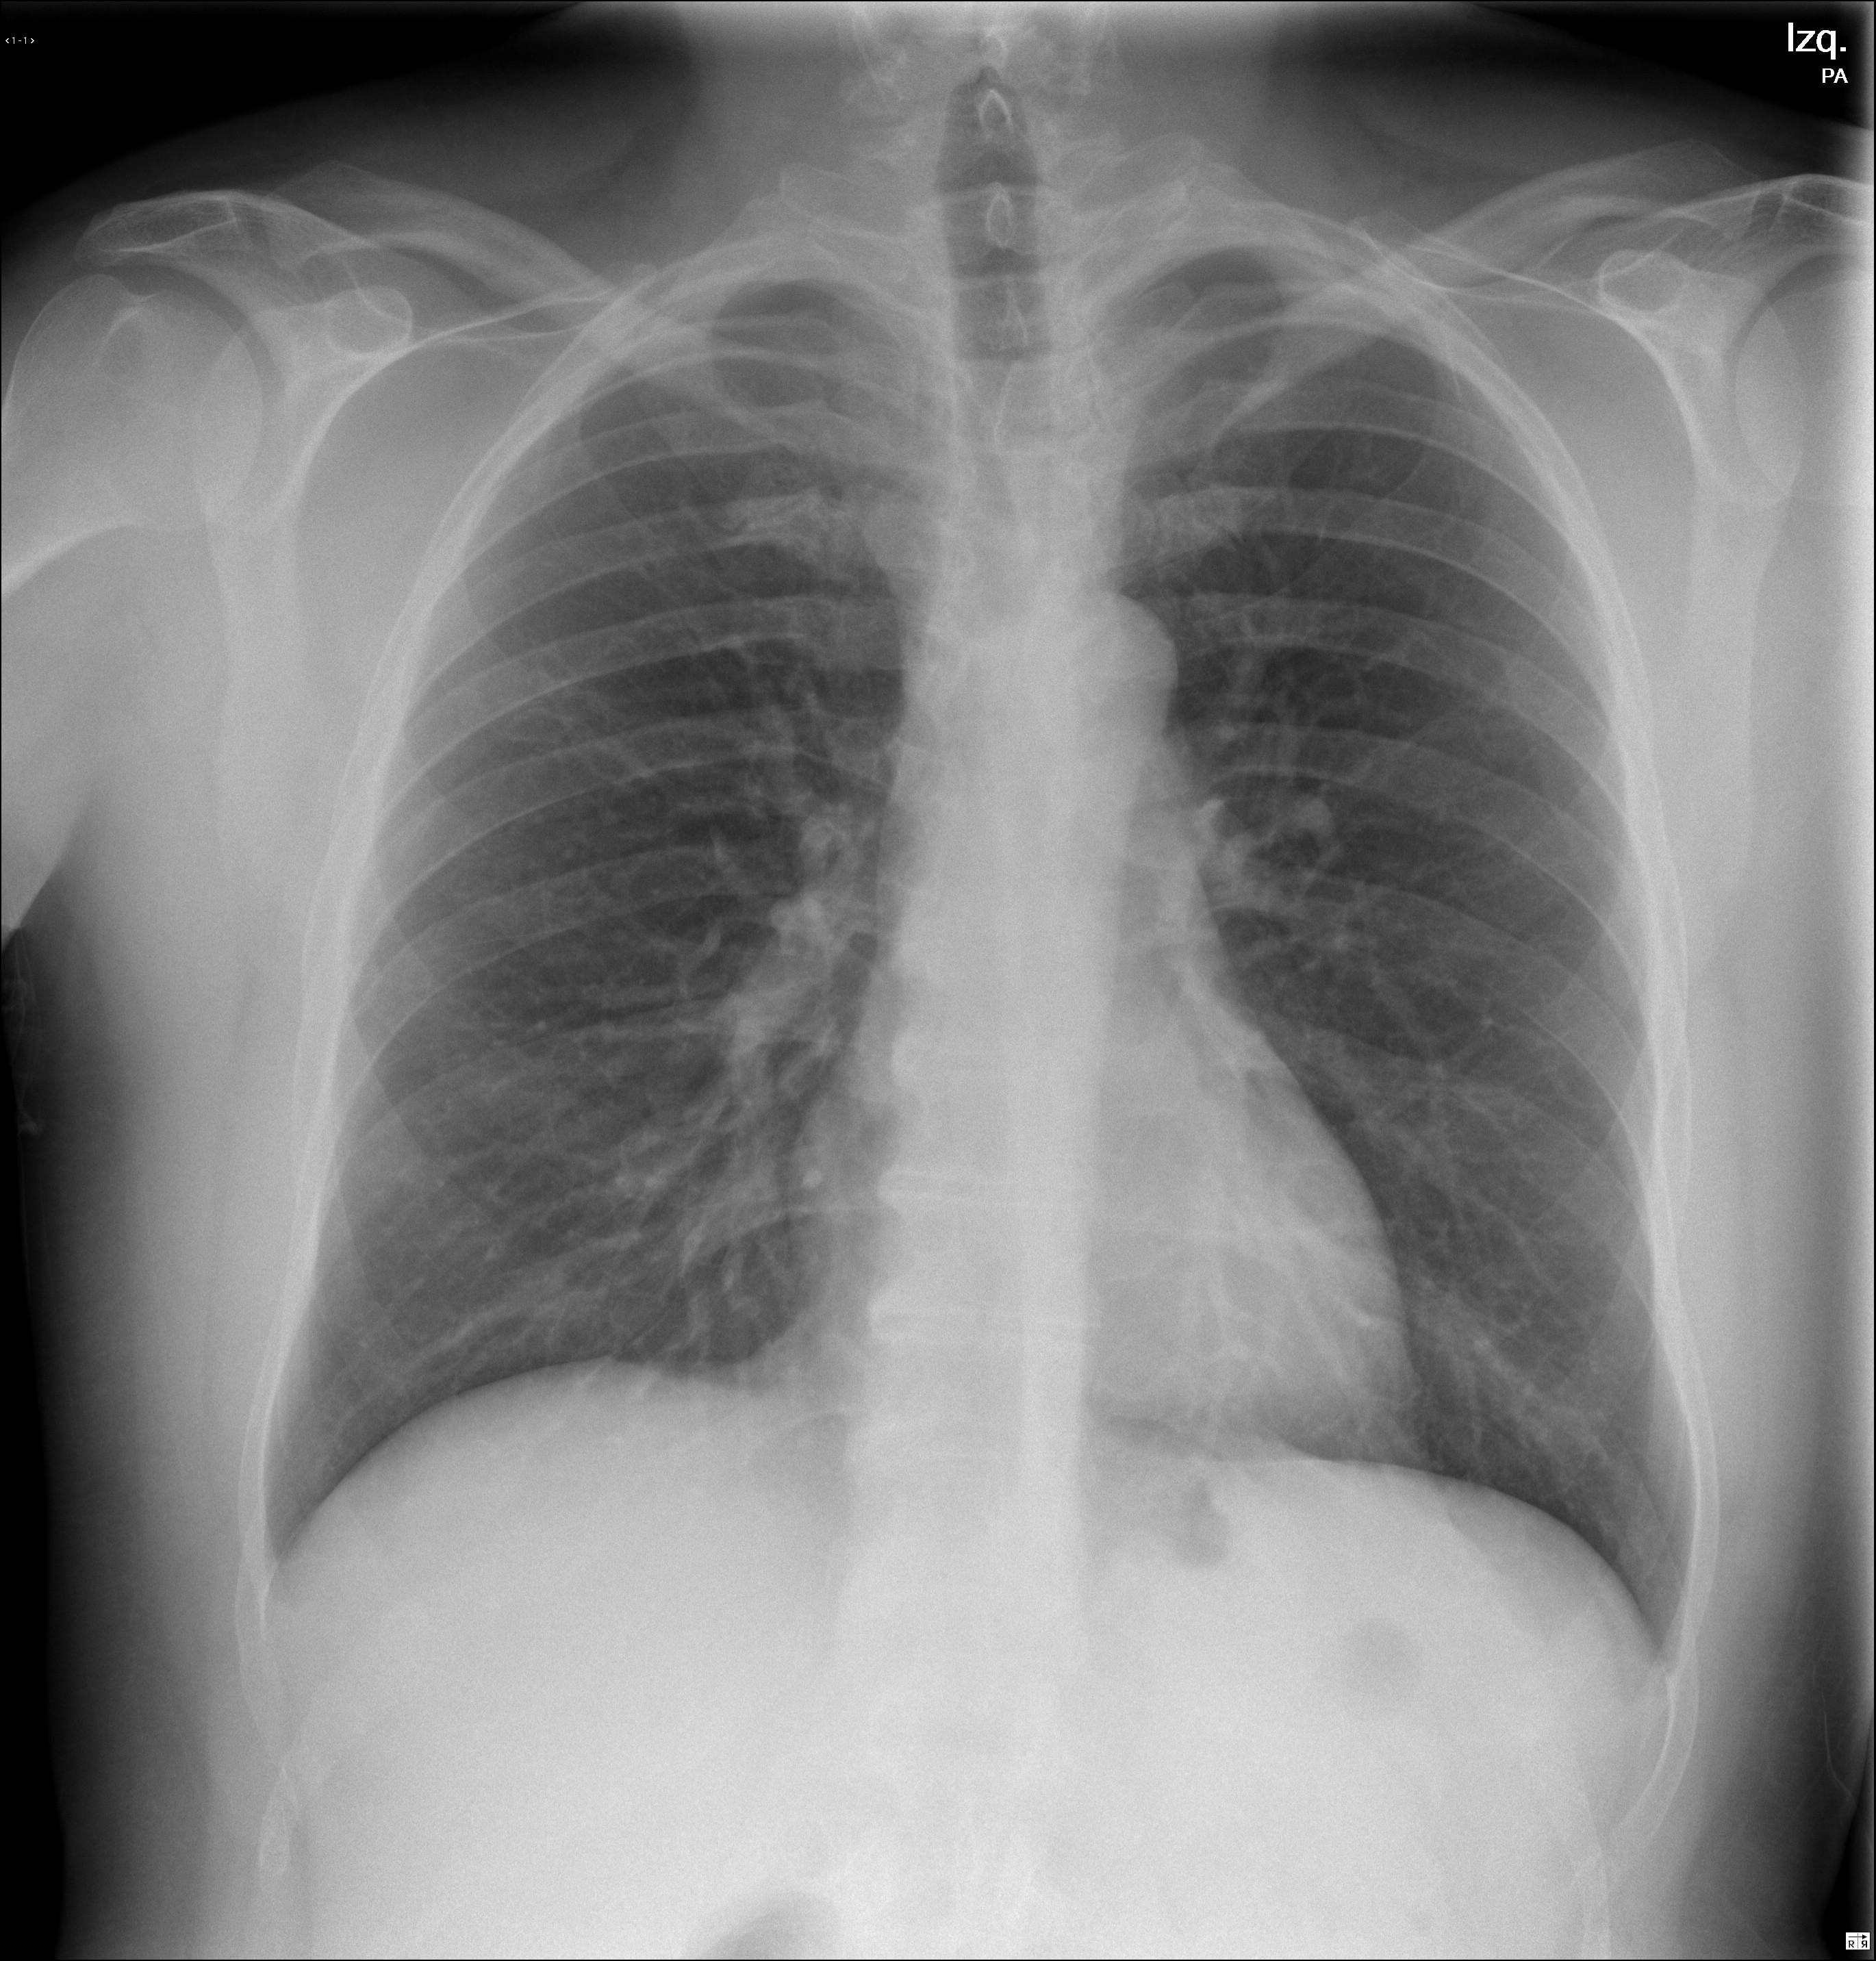

In [8]:
Image(train_path[1])
# Image(train_path[15])
# Image(train_path[66])

In [9]:
img = cv2.imread(train_path[1])

img.shape

(2864, 2740, 3)

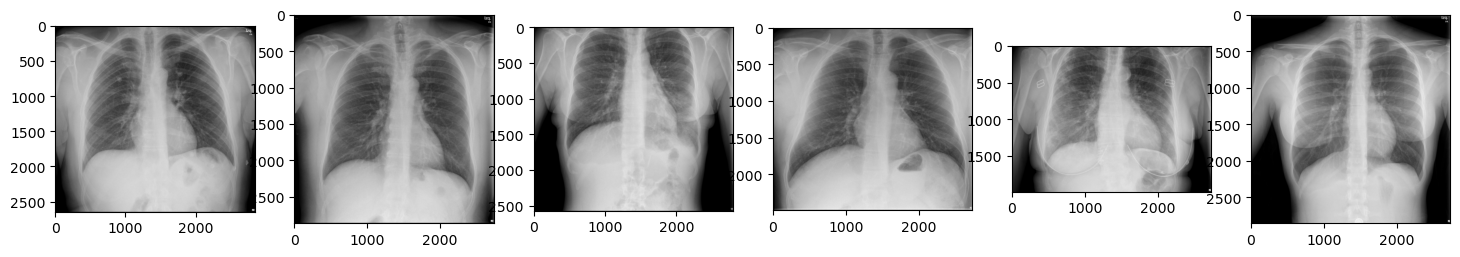

In [10]:
im = [cv2.imread(train_path[i]) for i in range(6)]

fig,ax = plt.subplots(ncols=6, figsize=(18,6))
for i in range(len(im)):
    ax[i].imshow(im[i],cmap='gray')

plt.show()

### Dataset Class



In [11]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=False):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == True):
            self.transforms = transforms.Compose([transforms.Grayscale(),
                                                  transforms.Resize((384, 384)),
                                                  transforms.ToTensor()])
        elif grayscale == False:
            self.transforms = transforms.Compose([transforms.Resize((384, 384)),
                                                  transforms.ToTensor()])
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

## 2. Model Development

### ResNet101

In [12]:
class ResNet101(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet101, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        in_features = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet101(x)
    
    def get_name(self):
        return 'ResNet101'

### ResNet50

In [13]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)
    
    def get_name(self):
        return 'ResNet50'


### EfficientNetB0

In [14]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB0, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)
    
    def get_name(self):
        return 'EfficientNetB0'

### EfficientNetB4

In [15]:
class EfficientNetB4(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB4, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b4')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)
    
    def get_name(self):
        return 'EfficientNetB4'

### EfficientNetB7

In [16]:
class EfficientNetB7(nn.Module):
    def __init__(self, num_classes=1):
        super(EfficientNetB7, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b7')
        in_features = self.effnet._fc.in_features
        self.effnet._fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.effnet(x)
    
    def get_name(self):
        return 'EfficientNetB7'

### VGG16

In [17]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vgg16(x)
    
    def get_name(self):
        return 'VGG16'

### ViTaeV2

In [18]:
import torch
import torch.nn as nn
import timm

class ViTaeV2(nn.Module):
    def __init__(self, num_classes=1):
        super(ViTaeV2, self).__init__()
        self.vit_model = timm.create_model('vit_base_patch16_384', pretrained=True)
        # Substitua 'vit_base_patch16_384' pelo nome do modelo Timm ViT que você quer usar

        # Ajuste a última camada para o número de classes desejado
        self.vit_model.head = nn.Linear(self.vit_model.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit_model(x)
        return x
    
    def get_name(self):
        return 'ViTaeV2'

c:\Users\Lucas\anaconda3\envs\torch000\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

# Define the training function
def train_model(model, train_dataset, val_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=7):
    model = model.to(device)

    # Construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Set up loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

    # Initialize variables to track the best validation loss and corresponding model state
    best_val_loss = float('inf')
    best_model_state = None

    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).view(-1)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
    
            cur_train_loss = criterion(outputs, labels)
            cur_train_acc = (pred == labels).sum().item() / batch_size

            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += cur_train_loss 
            train_acc += cur_train_acc
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images).view(-1)

                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss

                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)
                val_acc += (pred == labels).sum().item() / batch_size

        scheduler.step()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
    
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
    
        # Update the best model if validation loss is the lowest so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    test_acc = 0
    print(f'The best val loss is {best_val_loss}.\n\n')

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            test_acc += (pred == labels).sum().item()

    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')

    return history, model

Process the datasets and train the model

In [21]:
print("Current GPU memory usage:", torch.cuda.memory_allocated() / (1024 ** 2), "MB")
print("Max GPU memory usage:", torch.cuda.max_memory_allocated() / (1024 ** 2), "MB")

torch.cuda.empty_cache()

Current GPU memory usage: 0.0 MB
Max GPU memory usage: 0.0 MB


In [22]:
train_path[:5], train_label[:5]

(['C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets/P\\9fb692568312be08ea18fd58a6117168.jpg',
  'C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets/P\\2ef227ba17c60e5ae53b3ece6d875096.jpg',
  'C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets/P\\331c1cd5d8bc1ef77ad39ae19c6634a4.jpg',
  'C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets/N\\f32eff6296ef6f6241bb7db40860f4fc.jpg',
  'C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets/P\\52fb01a88a286ac5188da005aa9f3b1e.jpg'],
 array([1, 1, 1, 0, 1]))

In [23]:
train_dataset = CT_Dataset(img_path=train_path, img_labels=np.array(train_label))
valid_dataset = CT_Dataset(img_path=valid_path, img_labels=np.array(valid_label))
test_dataset = CT_Dataset(img_path=test_path, img_labels=np.array(test_label))

In [ ]:
batch_size = 32
epoch = 50


# Train the ResNet101 model
model_kernel = ResNet50(num_classes=7)
# model_kernel = ResNet101(num_classes=7)
# model_kernel = EfficientNetB(num_classes=7)
# model_kernel = EfficientNetB4(num_classes=7)
# model_kernel = EfficientNetB7(num_classes=7)
# model_kernel = VGG16(num_classes=7)



path_save_model = f'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/model_/{model_kernel.get_name()}_{epoch}'
hist_kernel, model_kernel = train_model(model_kernel, train_dataset, valid_dataset, test_dataset, device, path_save_model, lr=0.0002, batch_size= batch_size, epochs=epoch, l2=0.09, patience=5)

In [ ]:
65841hgtc

In [ ]:
label_model = model_kernel.get_name()
# model_kernel = model_ViTaeV2
# hist_kernel = hist_ViTaeV2

In [ ]:
path_save_model = f'C:/Users/Lucas/Documents/PIBIC/DATASET/COVIDGR_datasets/model_/{label_model}{epoch}'


torch.save(model_kernel.state_dict(), f'{path_save_model}.pth')

## Metricis

In [ ]:
def plot_metrics(hist, label_model) :
    # plot training curves
    epochs = range(1, len(hist['train_loss']) + 1)

    train_loss = [t.cpu().detach().numpy() for t in hist['train_loss']]
    val_loss = [t.cpu().detach().numpy() for t in hist['val_loss']]


    fig, ax = plt.subplots(1,2, figsize=(20,6))
    ax[0].plot(epochs, train_loss, 'r-', label='Train')
    ax[0].plot(epochs, val_loss, 'b-', label='Evaluation')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    plt.savefig(f'{path_save_model}_Loss.png')  # This saves the plot as a PNG image

    ax[1].plot(epochs, hist['train_acc'], 'r-', label='Train')
    ax[1].plot(epochs, hist['val_acc'], 'b-', label='Evaluation')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc')
    ax[1].legend()
    plt.savefig(f'{path_save_model}_Accuracy.png')  # This saves the plot as a PNG image
    

    plt.show()
    
    
plot_metrics(hist_kernel, label_model)

In [ ]:
def calculate_metrics(model, test_dataset, device, plot_images=False):
    # Initialize variables to store predictions and ground truth
    y_true = []
    y_pred = []
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (fn + tp)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'false negativo': fn
    }

    return metrics





model_path = f'{path_save_model}.pth'

if label_model[:7] == "ResNet1":
    model_kernel = ResNet101()

elif label_model[:7] == "ResNet5":
    model_kernel = ResNet50()

elif label_model[:14] == "EfficientNetB0":
    model_kernel = EfficientNetB0()
    
elif label_model[:14] == "EfficientNetB4":
    model_kernel = EfficientNetB4()

elif label_model[:14] == "EfficientNetB7":
    model_kernel = EfficientNetB7()

elif label_model[:5] == "VGG16":
    model_kernel = VGG16()


model_kernel.load_state_dict(torch.load(model_path))
model_kernel.to(device)  # Move the model to the specified device
model_kernel.eval()  # Set the model to evaluation mode

# Call the function with plot_images=True to plot images
metrics = calculate_metrics(model_kernel, test_dataset, device, plot_images=True)
metrics

In [ ]:
pd.DataFrame(metrics.items(), columns=['Metric', 'Value']).to_csv(f'{path_save_model}.csv')

In [ ]:
def process_images(model, test_dataset, device, plot_images=False, num_images_to_plot=10):
    # Initialize variables to store predictions and ground truth
    y_pred = []
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    images_plotted = 0  # Counter for the number of images plotted

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            y_pred.extend(predictions)

            # Plot images with true and predicted labels
            if plot_images and images_plotted < num_images_to_plot:
                plot_image(images, labels, predictions)
                images_plotted += 1

            # Break the loop if the desired number of images is plotted
            if images_plotted >= num_images_to_plot:
                break


def plot_image(images, true_label, predicted_label):
    if len(images.shape) == 4 and images.shape[1] == 3:
        # Convert CUDA tensor to numpy array and rearrange dimensions for RGB image
        images = images.cpu().detach().numpy().squeeze().transpose((1, 2, 0))
    else:
        # Convert CUDA tensor to numpy array and squeeze if necessary
        images = images.cpu().detach().numpy().squeeze()

    if len(images.shape) == 2:
        plt.imshow(images, cmap='gray')
    else:
        plt.imshow(images)
    
    # Format the labels
    true_label = true_label.item() if isinstance(true_label, torch.Tensor) else true_label
    predicted_label = predicted_label.item() if isinstance(predicted_label, torch.Tensor) else predicted_label
    
    plt.title(f'True label: {true_label}; Predicted: {predicted_label}')
    plt.show()
    
    
process_images(model_kernel, test_dataset, device, plot_images=True)

**Sugestão de Próximos Passos**

1. Colocar para salvar o modelo com a menor validation loss.
2. Colocar código para carregar o modelo salvo e fazer predições em imagens do dataset.
3. Criar métricas de acurácia (Accuracy, Precision, Recall, F-score, etc.) para avaliar o dataset de teste com o modelo salvo.

Quando tudo estiver pronto:
4. Criar novos modelos CNN (começar pela ResNet101).
5. Implementar outros modelos.

Quando estiver pronto:
6. Implementar no seu dataset.


Para binário tem que mudar a loss (CrossEntropy), a sigmoid da layer final para softmax

# Materiais e Métodos

## 1. Datasets

Explicação sobre os conjuntos de dados utilizados.

## 2. Modelos

Explicação sobre como funciona um modelo CNN (Convolutional Neural Network) e os parâmetros utilizados.

### 2.1. EfficientNet

### 2.2. ResNet101

...

## 3. Métricas


# Resultados